# Deep Neural Network From Scratch using Pytorch

In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
def one_hot_enc(y, num_labels=10):
    one_hot = torch.zeros(num_labels, y.shape[0])
    
    for i, val in enumerate(y):
        one_hot[val, i] = 1.0
        
    return one_hot

In [3]:
def add_bias_unit(layer, orientation):
    if orientation=='row':
        new_layer = torch.ones(layer.shape[0]+1, layer.shape[1])
        new_layer[1:, :] = layer
    elif orientation=='col':
        new_layer = torch.ones(layer.shape[0], layer.shape[1]+1)
        new_layer[:, 1:] = layer
        
    return new_layer

In [4]:
def init_weights(n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
    w1 = torch.randn((n_hidden_1, n_input+1), dtype=torch.float)
    w2 = torch.randn((n_hidden_2, n_hidden_1+1), dtype=torch.float)
    w3 = torch.randn((n_output, n_hidden_2+1), dtype=torch.float)
    
    return w1, w2, w3

In [5]:
def compute_forward_pass(input_, w1, w2, w3):
    a1 = torch.reshape(input_, shape=(input_.shape[0], -1))
    a1 = add_bias_unit(a1, orientation='col')
    
    z2 = w1.matmul(torch.transpose(a1, 0, 1))
    a2 = torch.sigmoid(z2)
    a2 = add_bias_unit(a2, orientation='row')
    
    z3 = w2.matmul(a2)
    a3 = torch.sigmoid(z3)
    a3 = add_bias_unit(a3, orientation='row')
    
    z4 = w3.matmul(a3)
    a4 = torch.sigmoid(z4)
    
    return a1, z2, a2, z3, a3, z4, a4

In [6]:
def predict(a4):
    prediction = torch.argmax(a4, dim=0)
    
    return prediction

In [7]:
def compute_loss(prediction, label):
    term_1 = -1*label*torch.log(prediction)
    term_2 = (1-label)*torch.log(1-prediction)
    loss = torch.sum(term_1 - term_2)
    
    return loss

In [8]:
# Reference for backpropagation: https://www.youtube.com/watch?v=tIeHLnjs5U8
        
def compute_backward_pass(weights, outputs, label):
    w1, w2, w3 = weights
    a1, z2, a2, z3, a3, z4, a4 = outputs
    
    delta_4 = a4 - label
    delta_3 = torch.transpose(w3[:, 1:], 0, 1).matmul(delta_4)*\
                torch.sigmoid(z3)*(1-torch.sigmoid(z3))
    delta_2 = w2[:, 1:].matmul(delta_3)*torch.sigmoid(z2)*(1-torch.sigmoid(z2))
    
    grad_w1 = delta_2.matmul(a1)
    grad_w2 = delta_3.matmul(torch.transpose(a2, 0, 1))
    grad_w3 = delta_4.matmul(torch.transpose(a3, 0, 1))
    
    return grad_w1, grad_w2, grad_w3         

In [9]:
def get_data(train_batch_size, test_batch_size=10):
    mnist_train_data = MNIST('mnist', train=True, download=True, transform = ToTensor())
    train_data_loader = torch.utils.data.DataLoader(mnist_train_data, 
                                                    batch_size = train_batch_size, 
                                                    shuffle=True, 
                                                    num_workers=4)
    mnist_test_data = MNIST('mnist', train=False, download=True, transform=ToTensor())
    test_data_loader = torch.utils.data.DataLoader(mnist_test_data,
                                                   batch_size = test_batch_size, 
                                                   shuffle=True,
                                                   num_workers=4)
    return train_data_loader, test_data_loader

## Train the model

In [10]:
batch_size = 50
n_input = 28*28

n_hidden_1, n_hidden_2, n_output = 100, 100, 10
w1, w2, w3 = init_weights(n_input, n_hidden_1, n_hidden_2, n_output, batch_size)

eta = 0.001 # learning rate
alpha = 0.001 # momentum factor

num_epochs = 100

delta_w1_prev = torch.zeros(w1.shape)
delta_w2_prev = torch.zeros(w2.shape)
delta_w3_prev = torch.zeros(w3.shape)

train_losses = []
train_acc = []

train_data, test_data = get_data(batch_size)

for i in range(num_epochs):
    for j, (input_, label) in enumerate(train_data):
        one_hot_label = one_hot_enc(label, num_labels=10)
        a1, z2, a2, z3, a3, z4, a4 = compute_forward_pass(input_, w1, w2, w3)
        loss = compute_loss(a4, one_hot_label.float())
        grad_1, grad_2, grad_3 = compute_backward_pass([w1, w2, w3], 
                                                       [a1, z2, a2, z3, a3, z4, a4], 
                                                       one_hot_label.float())
        
        delta_w1, delta_w2, delta_w3 = eta*grad_1, eta*grad_2, eta*grad_3
        w1 -= delta_w1 + delta_w1_prev*alpha
        w2 -= delta_w2 + delta_w2_prev*alpha
        w3 -= delta_w3 + delta_w3_prev*alpha
        
        delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
        
        train_losses.append(loss)
        predictions = predict(a4)
        
        wrong = torch.where(predictions!=label, torch.tensor([1.]), torch.tensor([0.]))
        acc = 1 - torch.sum(wrong)/batch_size
        train_acc.append(acc.float())
    print('epoic', i, 'training accuracy %2f' %torch.mean(torch.tensor(train_acc)).item())

epoic 0 training accuracy 0.456967
epoic 1 training accuracy 0.578108
epoic 2 training accuracy 0.639717
epoic 3 training accuracy 0.678187
epoic 4 training accuracy 0.705436
epoic 5 training accuracy 0.725969
epoic 6 training accuracy 0.742378
epoic 7 training accuracy 0.755904
epoic 8 training accuracy 0.767273
epoic 9 training accuracy 0.777055
epoic 10 training accuracy 0.785650
epoic 11 training accuracy 0.793221
epoic 12 training accuracy 0.799977
epoic 13 training accuracy 0.806108
epoic 14 training accuracy 0.811718
epoic 15 training accuracy 0.816867
epoic 16 training accuracy 0.821574
epoic 17 training accuracy 0.825951
epoic 18 training accuracy 0.830034
epoic 19 training accuracy 0.833805
epoic 20 training accuracy 0.837298
epoic 21 training accuracy 0.840605
epoic 22 training accuracy 0.843682
epoic 23 training accuracy 0.846598
epoic 24 training accuracy 0.849342
epoic 25 training accuracy 0.851949
epoic 26 training accuracy 0.854400
epoic 27 training accuracy 0.856725
ep

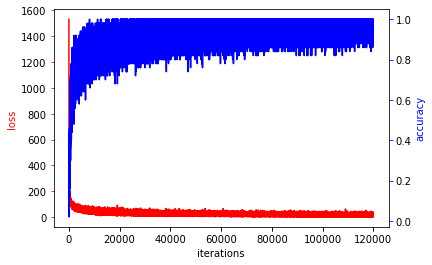

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, label='1')
ax2 = fig.add_subplot(111, label='2', frame_on=False)
ax.plot(train_losses, color='red')
ax.set_xlabel('iterations')
ax.set_ylabel('loss', color='red')
ax.tick_params(axis='y', color='red')
ax2.plot(train_acc, color='blue')
ax2.yaxis.tick_right()
ax2.set_ylabel('accuracy', color='blue')
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='y', color='blue')
ax2.set_xticklabels([])
plt.show()

## Evaluate on test data

In [12]:
test_acc = []

for j, (input_, label) in enumerate(test_data):
    one_hot_label = one_hot_enc(label, num_labels=10)
    a1, z2, a2, z3, a3, z4, a4 = compute_forward_pass(input_, w1, w2, w3)
    loss = compute_loss(a4, one_hot_label.float())

    predictions = predict(a4)
    wrong = torch.where(predictions!=label, torch.tensor([1.]), torch.tensor([0.]))
    acc = 1 - torch.sum(wrong)/batch_size
    test_acc.append(acc.float())
print('testing accuracy %2f' %torch.mean(torch.tensor(test_acc)).item())

testing accuracy 0.989100


In [22]:
import numpy as np
A = torch.tensor([[1, 2, 3], [4, 5, 6]])
B = torch.tensor([7, 8, 9])

In [15]:
A

tensor([[1, 2, 3],
        [4, 5, 6]], dtype=torch.int32)

In [16]:
B

tensor([7, 8, 9], dtype=torch.int32)

In [19]:
A.matmul(B)

tensor([ 50, 122], dtype=torch.int32)